# Calcul de l'empreinte carbone du secteur de l'énergie solaire (photovoltaïque).

Plan:

- [x] Calculer les émissions directes de la production d'électricité photovoltaïque pour certains pays (France, Allemagne, Chine, etc.) pour l'année complète. Aller dans F ou io.impact(s).F.
-> où ont lieu les émissions?
- [x] Regarder l'empreinte dans D_cba : voir quels pays sont meilleurs que les autres. Ramener au kWh (aller chercher les données ailleurs: on divise par la production annuelle en 2019).
-> où a lieu l'empreinte?
- [ ] Estimer l'impact de la production d'un M€ de panneaux, que ce soit en Chine ou en France. (Utiliser le tableau envoyé.)
- [ ] Mettre à l'échelle (multiplier l'empreinte/M€ par l'investissement prévu jusqu'en 2030).

## Importation des librairies et données

In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle

doi = '10.5281/zenodo.5589597'
EXIOBASE_PATH = 'EXIOBASE/'
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

io = mr.parse_exiobase3(path=filename)

population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

io.calc_all()

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:935: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:935: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort

## Tests et prise en main

Calcul de la production photovoltaïque française.

In [2]:
io.x.loc['FR','Production of electricity by solar photovoltaic']

indout    35.435103
Name: (FR, Production of electricity by solar photovoltaic), dtype: float64

35,4M € ont été produits par le solaire en 2019.

In [3]:
purchases = io.Z['FR','Production of electricity by solar photovoltaic'].sort_values(ascending=False)
purchases.head()

region  sector                                                                                             
FR      Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                    14.235806
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)    10.117219
        Sea and coastal water transport                                                                         0.394177
        Transport via pipelines                                                                                 0.371194
        Retail sale of automotive fuel                                                                          0.291439
Name: (FR, Production of electricity by solar photovoltaic), dtype: float64

In [4]:
purchases.sum()

29.47355737463697

Le secteur achète 29.47 M€ d'équipements/services (wholesale = vente de gros = producteurs, et retail = vente de détail = particuliers). Majorité provenant du commerce.

In [5]:
index = ((slice(None),'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'),
         ('FR','Production of electricity by solar photovoltaic'))

In [6]:
direct = io.A.loc[index].sort_values(ascending=False).head()
direct_indirect = io.L.loc[index].sort_values(ascending=False).head()
indirect = (direct_indirect - direct)

<Axes: xlabel='region'>

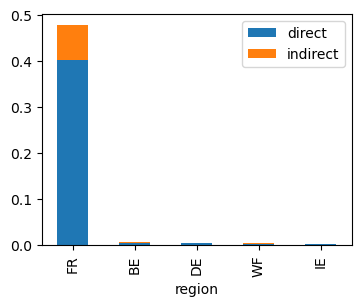

In [7]:
pd.concat([direct,indirect],axis=1,keys=('direct','indirect')).sort_values(by='direct',ascending=False).head().droplevel(1).plot(kind='bar',stacked=True,figsize=(4,3))

Parmi les dépenses principales du secteur, on a l'achat de gros. La production solaire achète principalement en France, avec 0,40€ de dépenses directes par euro produit mais aussi 0,60€ de dépenses indirectes versées aux grossistes. 

Voir http://www.energies-renouvelables.org/observ-er/etudes/Observ-ER-Etude-2019-marche-photovoltaique-2018-20201127.pdf pour les prix moyens d'installation en 2019.

La puissance du parc solaire photovoltaïque atteint 9,9 GW, fin décembre 2019. https://www.statistiques.developpement-durable.gouv.fr/tableau-de-bord-solaire-photovoltaique-quatrieme-trimestre-2019

In [8]:
impact = io.satellite.F['FR','Production of electricity by solar photovoltaic'].head(30)
impact # Impact/émissions directs de la production de photov. en France sur l'année.

# impact = io.satellite.S['FR','Production of electricity by solar photovoltaic'].head(30) Par million d'euros.

stressor
Taxes less subsidies on products purchased: Total                                                2.688425e-02
Other net taxes on production                                                                    1.723229e-03
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled       1.156455e-04
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1.691970e-03
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      3.599038e-03
Operating surplus: Consumption of fixed capital                                                  5.893079e+00
Operating surplus: Rents on land                                                                 0.000000e+00
Operating surplus: Royalties on resources                                                        0.000000e+00
Operating surplus: Remaining net operating surplus                                               3.445237e-02
E

Regarder la table et se demander ce qu'on pourrait gagner à ramener la production de panneaux photovoltaïques en France.

Matrice Z: tout ce qui est produit et consommé sur une année
Matrice F : tout ce qui est consommé à partir d'autre chose que l'économie annuelle. Approvisionnement à partir de ressources, provient du bâti (eg. gross fixed capital) et masse salariale.

In [9]:
impact2 = io.satellite.D_cba['FR','Production of electricity by solar photovoltaic'].head(30) # consumption-based account
impact2 # Émissions sur le cylce de vie de la production totale de photovoltaïque en France de ce qui est installé en 2019.

stressor
Taxes less subsidies on products purchased: Total                                                6.836523e-03
Other net taxes on production                                                                    1.943110e-03
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled       2.887755e-03
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1.860910e-02
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      1.096635e-02
Operating surplus: Consumption of fixed capital                                                  2.357188e-01
Operating surplus: Rents on land                                                                 0.000000e+00
Operating surplus: Royalties on resources                                                        0.000000e+00
Operating surplus: Remaining net operating surplus                                               2.507674e-02
E

## Émissions directes de la production d'électricité

Les émissions directes (en volume, par an) sont issues de la matrice F.

### CO2 seul

In [10]:
co2 = 'CO2 - combustion - air'

In [11]:
io.satellite.F.loc[co2, ('FR','Production of electricity by solar photovoltaic')]

16168786.63

In [12]:
electricity = [s for s in io.get_sectors() if 'electricity' in s]
electricity

['Production of electricity by coal',
 'Production of electricity by gas',
 'Production of electricity by nuclear',
 'Production of electricity by hydro',
 'Production of electricity by wind',
 'Production of electricity by petroleum and other oil derivatives',
 'Production of electricity by biomass and waste',
 'Production of electricity by solar photovoltaic',
 'Production of electricity by solar thermal',
 'Production of electricity by tide, wave, ocean',
 'Production of electricity by Geothermal',
 'Production of electricity nec',
 'Transmission of electricity',
 'Distribution and trade of electricity']

<Axes: xlabel='region,sector', ylabel='kg CO2/year'>

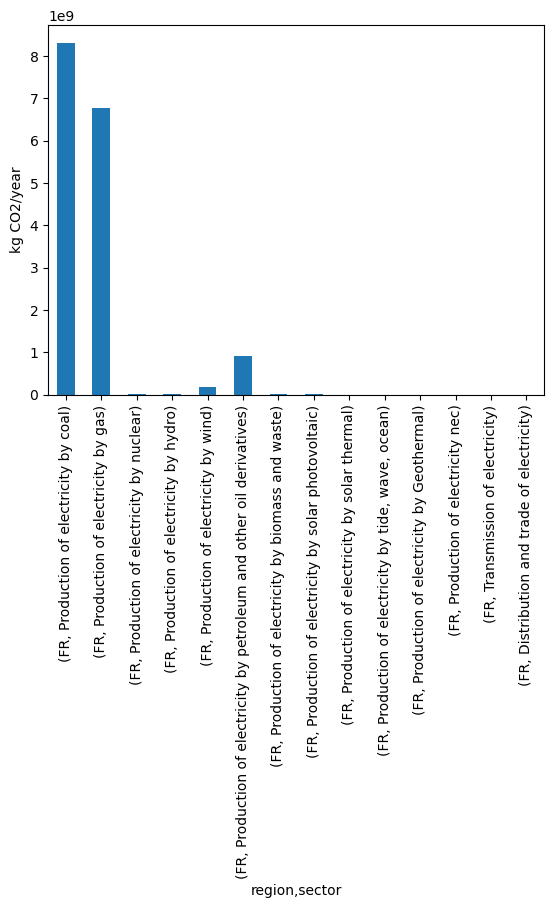

In [13]:
io.satellite.F.loc[co2, ('FR', electricity)].plot.bar(ylabel='kg CO2/year')

### Gaz à effet de serre

In [14]:
ghg = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

In [15]:
io.impacts.F.loc[ghg, ('FR', electricity)]

region  sector                                                          
FR      Production of electricity by coal                                   8.364990e+09
        Production of electricity by gas                                    6.841170e+09
        Production of electricity by nuclear                                1.301764e+07
        Production of electricity by hydro                                  2.734455e+06
        Production of electricity by wind                                   1.851153e+08
        Production of electricity by petroleum and other oil derivatives    9.112243e+08
        Production of electricity by biomass and waste                      7.720638e+06
        Production of electricity by solar photovoltaic                     1.702000e+07
        Production of electricity by solar thermal                          0.000000e+00
        Production of electricity by tide, wave, ocean                      4.971230e+03
        Production of electricity by 

## Empreinte totale de la production d'électricité

### France

<Axes: xlabel='region,sector'>

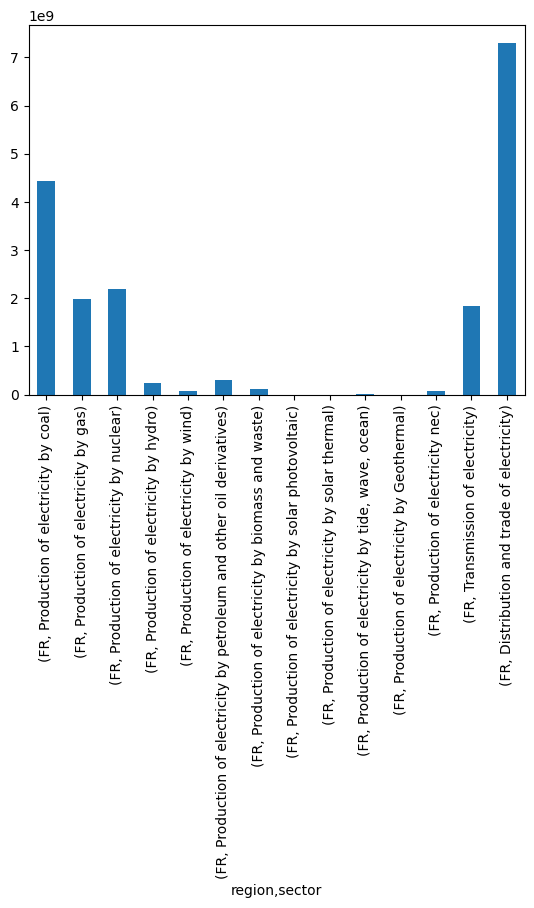

In [16]:
io.impacts.D_cba.loc[ghg, ('FR', electricity)].plot.bar()

In [17]:
elec_ghg = io.impacts.D_cba.loc[ghg, ('FR', electricity)].sum()
elec_ghg

18574142705.681667

Émissions selon [RTE](https://assets.rte-france.com/prod/public/2020-06/bilan-electrique-2019_1_0.pdf): 19.2 Mt CO2 (CO2 seul)
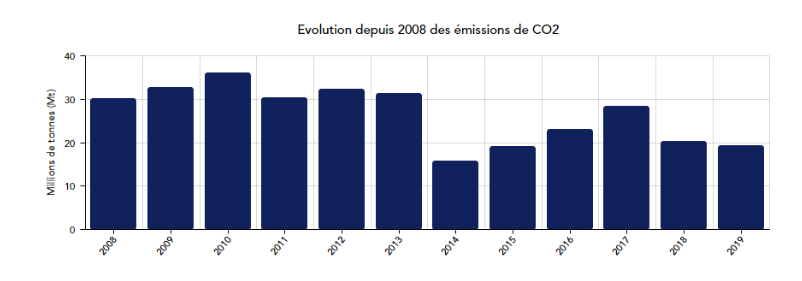

In [18]:
# Consommation totale en 2019
# https://assets.rte-france.com/prod/public/2020-06/bilan-electrique-2019_1_0.pdf
total_cons = 474e9 # kWh/an

In [19]:
elec_ghg / total_cons

0.03918595507527778

L'intensité carbone moyenne de l'électricité française en 2019 s'élève à environ 40 g CO2 eq./kWh.
C'est relativement différent de ce qui est trouvé par [electricitymaps](https://app.electricitymaps.com/zone/FR/all/2023-01-01T00:00:00.000Z#carbon_chart).

### Monde

In [21]:
s_ghg = io.impacts.S.loc[ghg]

In [22]:
# Plus gros émetteurs de GES par pays et source
ghg_prod_cons = io.L.mul(s_ghg).mul(io.Y.sum(1), axis=1)
ghg_prod_cons.loc[:,(slice(None),electricity)].sum().nlargest(20)

region  sector                                                          
US      Production of electricity by coal                                   9.447352e+11
IN      Production of electricity by coal                                   7.568044e+11
US      Production of electricity by gas                                    4.773126e+11
AU      Production of electricity by coal                                   2.171356e+11
WM      Production of electricity by gas                                    1.896808e+11
DE      Production of electricity by coal                                   1.677897e+11
WM      Production of electricity by petroleum and other oil derivatives    1.662673e+11
WA      Production of electricity by coal                                   1.546289e+11
        Production of electricity by gas                                    1.491213e+11
JP      Production of electricity by gas                                    9.993336e+10
KR      Production of electricity by 

In [23]:
ghg_prod_cons[('CN', 'Production of electricity by coal')].nlargest()

region  sector                                                             
CN      Production of electricity by coal                                      3.543839e+08
        Mining of coal and lignite; extraction of peat (10)                    1.167143e+08
        Financial intermediation, except insurance and pension funding (65)    5.577523e+07
        Other business activities (74)                                         3.763206e+07
        Manufacture of electrical machinery and apparatus n.e.c. (31)          3.542286e+07
Name: (CN, Production of electricity by coal), dtype: float64

In [24]:
ghg_prod_cons_elec = ghg_prod_cons.loc[:,(slice(None),electricity)]
ghg_prod_cons_elec.groupby('region', axis=1).sum().sum().nlargest(20)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_15616\3426025259.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ghg_prod_cons_elec.groupby('region', axis=1).sum().sum().nlargest(20)


region
US    1.457982e+12
IN    8.159864e+11
WM    3.750224e+11
WA    3.524278e+11
AU    2.647135e+11
JP    2.169772e+11
DE    1.881117e+11
WL    1.523640e+11
KR    1.388118e+11
MX    1.376963e+11
WF    1.281244e+11
ID    1.231253e+11
WE    9.253037e+10
TR    8.147332e+10
BR    7.168494e+10
GB    5.492224e+10
IT    4.671041e+10
RU    3.623613e+10
ES    3.348848e+10
CA    2.576111e+10
dtype: float64

# Solaire

In [25]:
y_solar = io.Y.sum(1).copy()
y_solar.loc[:,:] = 0

y_solar[('FR', 'Production of electricity by solar photovoltaic')] = 1

In [75]:
# Quels secteurs émettent le plus en cycle de vie, dans la chaîne de valeur d'1M€ de production PV en France
io.L.mul(s_ghg)[('FR', 'Production of electricity by solar photovoltaic')].nlargest(20)

region  sector                                                                                             
FR      Production of electricity by solar photovoltaic                                                        480317.933554
        Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                    229544.817699
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)    138362.397950
        Other business activities (74)                                                                          21671.512505
        Other land transport                                                                                    14190.941863
        Supporting and auxiliary transport activities; activities of travel agencies (63)                       13062.745381
        Real estate activities (70)                                                                             11541.283252
        Transport

In [76]:
# Quel est la part d'émissions directes dues à la demande (directe) d'1M€ de PV
io.A.mul(s_ghg)[('FR', 'Production of electricity by solar photovoltaic')].nlargest(20)

region  sector                                                                                                             
FR      Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                                    192963.093594
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)                    137136.592243
        Sea and coastal water transport                                                                                          5342.975575
        Transport via pipelines                                                                                                  5031.450732
        Retail sale of automotive fuel                                                                                           3950.385283
        Manufacture of gas; distribution of gaseous fuels through mains                                                          3074.835739
CN      Sea and coastal water 

In [27]:
io.L.mul(s_ghg).loc[:,(slice(None),electricity)].sum()

region  sector                               
AT      Production of electricity by coal        9.352258e+06
BE      Production of electricity by coal        1.337650e+07
BG      Production of electricity by coal        4.770883e+07
CY      Production of electricity by coal        0.000000e+00
CZ      Production of electricity by coal        6.621099e+06
                                                     ...     
WA      Distribution and trade of electricity    1.420976e+04
WL      Distribution and trade of electricity    1.724143e+03
WE      Distribution and trade of electricity    2.732213e+04
WF      Distribution and trade of electricity    8.756606e+05
WM      Distribution and trade of electricity    1.352665e+04
Length: 686, dtype: float64

In [28]:
io.L.mul(s_ghg).groupby('region', axis=0).sum().xs('Production of electricity by solar photovoltaic', level='sector', axis=1)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_15616\1794766336.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  io.L.mul(s_ghg).groupby('region', axis=0).sum().xs('Production of electricity by solar photovoltaic', level='sector', axis=1)


region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
region,,,,,,,,,,,,,,,,,,,,,
AT,9.325126e+06,234.993272,0.0,15.435483,1.468927e+07,1.214370e+04,9.906534e+03,0.0,0.070076,2.430148e+04,...,0.0,25.793366,0.0,0.0,2.757208e+04,25.881521,0.000000e+00,0.0,2.167835e+03,2.286043e-06
AU,4.692062e+03,177.547099,0.0,7.017727,1.589920e+06,1.645794e+03,6.109444e+03,0.0,0.074346,9.981518e+03,...,0.0,155.968375,0.0,0.0,6.171025e+04,402.221670,0.000000e+00,0.0,3.600787e+03,5.567837e-06
BE,1.628826e+04,209891.318318,0.0,31.992927,9.788942e+06,1.215119e+04,6.869400e+03,0.0,0.263771,6.434788e+04,...,0.0,17.318171,0.0,0.0,4.511627e+05,227.946570,0.000000e+00,0.0,1.362604e+04,4.502855e-06
BG,3.266981e+03,64.076030,0.0,7.301559,1.836457e+06,1.133823e+03,2.552350e+03,0.0,0.013054,2.676088e+03,...,0.0,2.549563,0.0,0.0,8.397247e+03,4.979252,0.000000e+00,0.0,3.967310e+02,8.603001e-07
BR,1.921856e+03,147.393356,0.0,31.901287,1.415272e+06,1.363126e+03,1.731267e+03,0.0,0.131023,7.660163e+03,...,0.0,136.186094,0.0,0.0,4.213037e+04,56.009691,0.000000e+00,0.0,6.286764e+03,6.402399e-06
CA,2.514885e+03,260.821633,0.0,4.092905,1.278830e+06,1.541044e+03,2.718101e+03,0.0,0.066713,1.273401e+04,...,0.0,39.020203,0.0,0.0,2.090072e+04,54.272136,0.000000e+00,0.0,3.509494e+03,3.138281e-06
CH,3.253741e+04,1027.673405,0.0,19.882028,8.894636e+06,1.266792e+04,2.534002e+04,0.0,0.321956,5.709932e+04,...,0.0,34.819719,0.0,0.0,7.433647e+04,100.168268,0.000000e+00,0.0,5.731529e+03,3.336613e-06
CN,3.594264e+04,1862.611345,0.0,69.412659,4.669491e+07,2.743200e+04,1.238268e+04,0.0,0.804632,1.831598e+05,...,0.0,318.956321,0.0,0.0,7.014500e+05,2969.440955,0.000000e+00,0.0,1.962450e+05,7.574180e-05
CY,8.436544e+02,15.700806,0.0,15487.964545,5.268545e+05,1.611665e+02,1.287558e+03,0.0,0.001911,2.576253e+03,...,0.0,0.899393,0.0,0.0,1.917559e+03,4.062055,0.000000e+00,0.0,7.832908e+01,1.916578e-07


In [29]:
ghg_prod_cons = io.L.mul(s_ghg).mul(io.Y.sum(1), axis=1)
ghg_prod_cons_elec = ghg_prod_cons.loc[:,(slice(None),electricity)]
ghg_prod_cons_elec.groupby('region', axis=1).sum().sum().nlargest(20)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_15616\1621255353.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ghg_prod_cons_elec.groupby('region', axis=1).sum().sum().nlargest(20)


region
US    1.457982e+12
IN    8.159864e+11
WM    3.750224e+11
WA    3.524278e+11
AU    2.647135e+11
JP    2.169772e+11
DE    1.881117e+11
WL    1.523640e+11
KR    1.388118e+11
MX    1.376963e+11
WF    1.281244e+11
ID    1.231253e+11
WE    9.253037e+10
TR    8.147332e+10
BR    7.168494e+10
GB    5.492224e+10
IT    4.671041e+10
RU    3.623613e+10
ES    3.348848e+10
CA    2.576111e+10
dtype: float64

Il faut maintenant modéliser les investissements nécessaires à l'installation d'un panneau photovoltaïque.

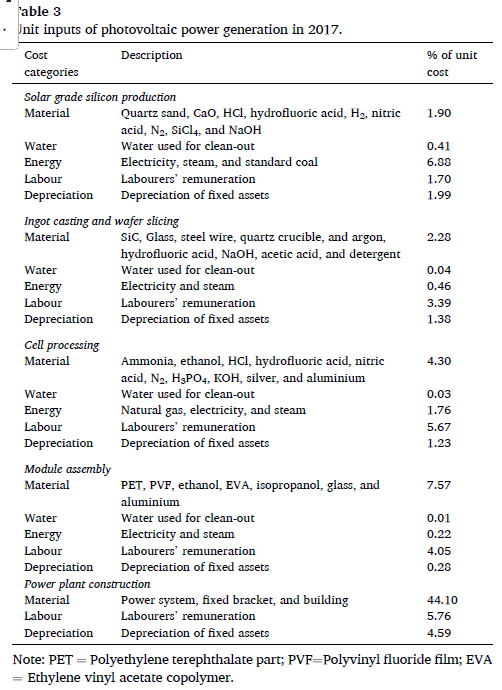

In [34]:
pd.DataFrame(io.get_sectors()).to_excel('miniprojet_mines/io_sectors.xlsx')

In [37]:
pd.DataFrame(io.satellite.F.index).to_excel('miniprojet_mines/io_factors.xlsx')

In [ ]:
demand_pv = 

In [38]:
ghg

'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

In [39]:
io.impacts.D_cba[('FR', 'Production of electricity by solar photovoltaic')]

impact
Value Added                                                                                       3.020384e-01
Employment                                                                                        1.025559e-01
Employment hour                                                                                   2.258134e+05
GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)    1.156433e+06
Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)                              4.550097e-02
                                                                                                      ...     
Unused Domestic Extraction - Oil and Gas                                                          1.283050e-03
Unused Domestic Extraction - Non-metalic Minerals                                                 3.494455e-03
Unused Domestic Extraction - Iron Ore                                                             6.96736

In [42]:
y_solar.nlargest()

region  sector                                         
FR      Production of electricity by solar photovoltaic    1.0
AT      Cultivation of paddy rice                          0.0
        Cultivation of wheat                               0.0
        Cultivation of cereal grains nec                   0.0
        Cultivation of vegetables, fruit, nuts             0.0
dtype: float64

In [43]:
x = io.L @ y_solar

In [44]:
F = io.impacts.S.mul(x, axis=1)

In [48]:
impacts_pv_fr = F.groupby('region', axis=1).sum()


C:\Users\Gibon\AppData\Local\Temp\ipykernel_15616\1131816472.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  impacts_pv_fr = F.groupby('region', axis=1).sum()


In [51]:
impacts_pv_fr_domestic = impacts_pv_fr['FR']

In [52]:
impacts_pv_fr_foreign = impacts_pv_fr.sum(axis=1) - impacts_pv_fr['FR']

In [66]:
impacts_pv_fr_reg = pd.concat([impacts_pv_fr_domestic, impacts_pv_fr_foreign], axis=1, keys=['France', 'Étranger']).div(impacts_pv_fr.sum(axis=1), axis=0).sort_values(ascending=False, by='France')

<Axes: ylabel='impact'>

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128 (\x80) missing from current font.
  func(*args, **kwargs)
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 147 (\x93) missing from current font.
  func(*args, **kwargs)
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


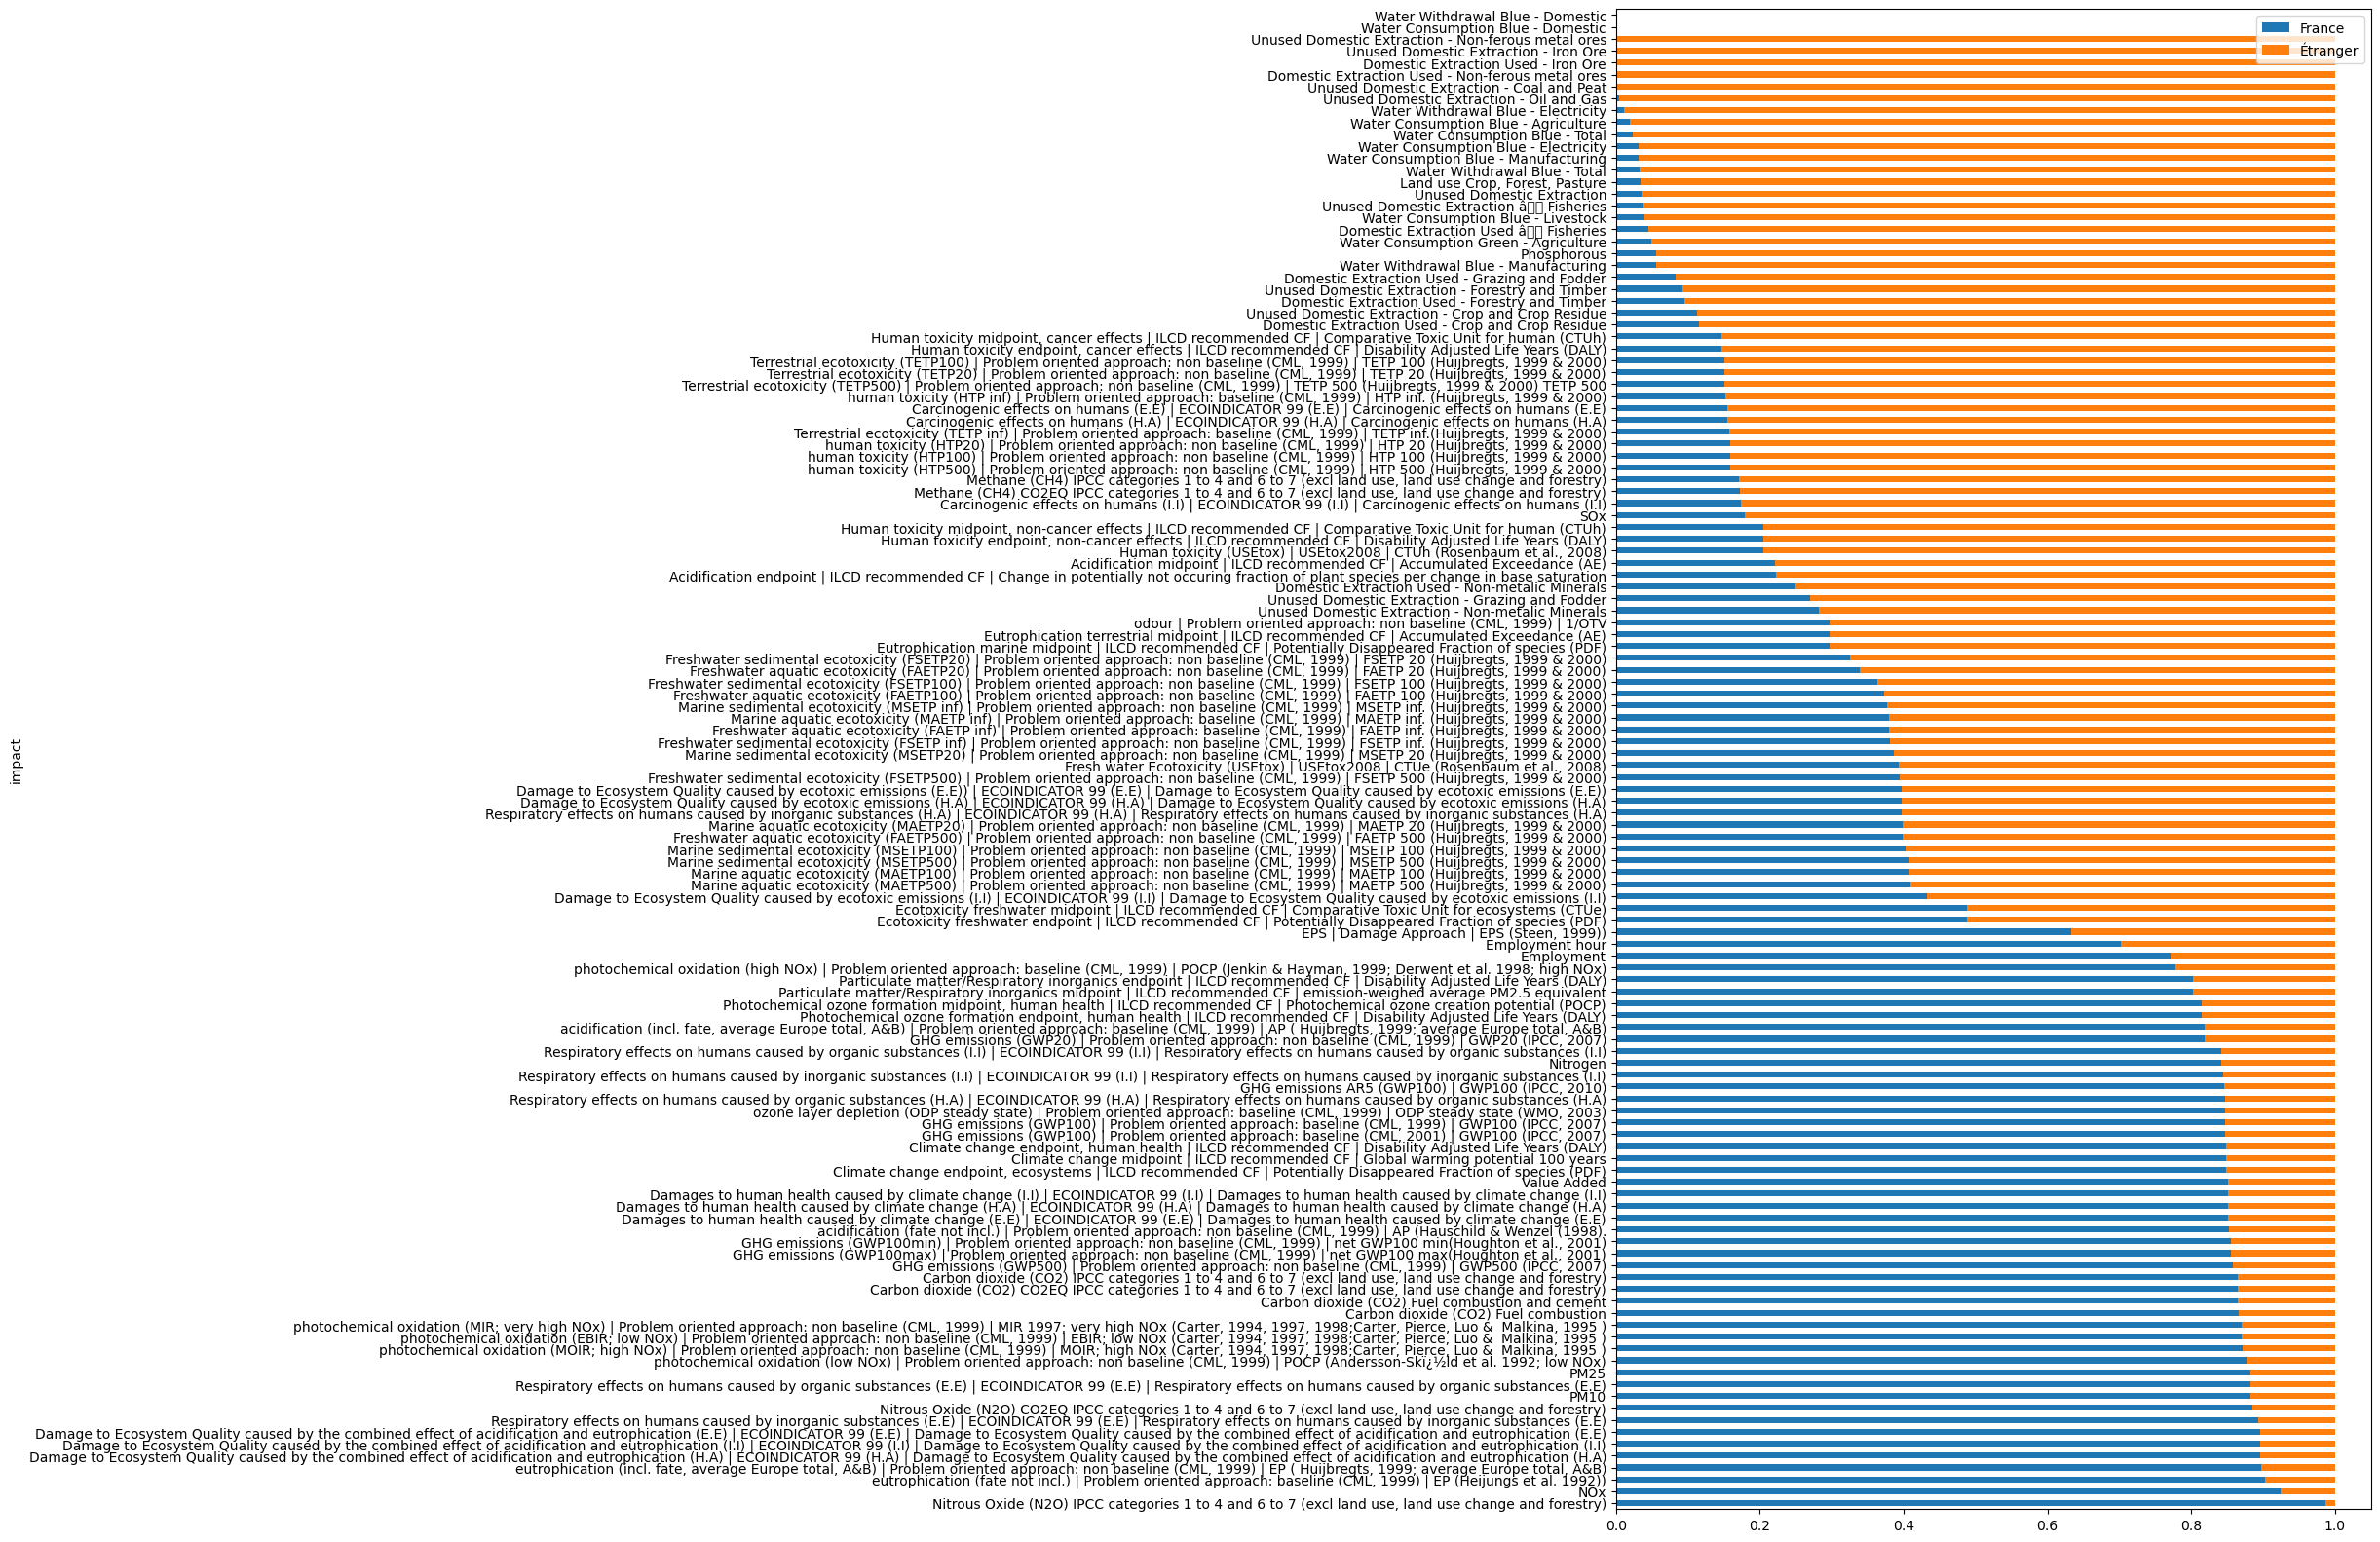

In [70]:
impacts_pv_fr_reg.plot.barh(stacked=True, figsize=(10,20))

In [73]:
io.L[('FR', 'Production of electricity by solar photovoltaic')].nlargest(20)

region  sector                                                                                             
FR      Production of electricity by solar photovoltaic                                                        1.000007
        Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                    0.477905
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)    0.288066
        Other business activities (74)                                                                         0.045119
        Other land transport                                                                                   0.029545
        Supporting and auxiliary transport activities; activities of travel agencies (63)                      0.027196
        Real estate activities (70)                                                                            0.024029
        Transport via pipelines                     